# Comparación de eficacia
### Modelos de Clasificación

### Librerías necesarias

In [64]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import Normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

### Generación de datos a usar

In [65]:
# 1. Cargar los datos
df = pd.read_csv('../train.csv')

# 2. Crear la variable de respuesta categórica basada en los terciles del precio de venta
tercil_1 = df['SalePrice'].quantile(1/3)
tercil_2 = df['SalePrice'].quantile(2/3)

# Crear la categoría de precio
df['PriceCategory'] = pd.cut(
    df['SalePrice'], 
    bins=[0, tercil_1, tercil_2, float('inf')], 
    labels=['Económica', 'Intermedia', 'Cara']
)

print(f"Tercil 1 (33.33%): ${int(tercil_1):,}")
print(f"Tercil 2 (66.67%): ${int(tercil_2):,}")

# 3. Seleccionar las características para el modelo
selected_features = [
    'OverallQual',    # Calidad general
    'GrLivArea',      # Área habitable
    'GarageCars',     # Capacidad del garaje
    'YearBuilt',      # Año de construcción
    'TotalBsmtSF',    # Superficie total del sótano
    'FullBath',       # Baños completos
    'Neighborhood',   # Vecindario (categórica)
    'ExterQual',      # Calidad del exterior (categórica)
    'KitchenQual',    # Calidad de la cocina (categórica)
    'BsmtQual'        # Calidad del sótano (categórica)
]

# 4. Preparar los datos
X = df[selected_features].copy()
y = df['PriceCategory']

# Manejar valores faltantes en características numéricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(strategy='median')
X[numeric_features] = imputer.fit_transform(X[numeric_features])

# Manejar valores faltantes en características categóricas
categorical_features = X.select_dtypes(include=['object']).columns
X[categorical_features] = X[categorical_features].fillna('None')

# Objetos de preprocesamiento para pipeline de modelos
preprocesador_categorico = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocesador_numerico = StandardScaler()

# 5. Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

Tercil 1 (33.33%): $139,699
Tercil 2 (66.67%): $190,000


In [66]:
# Generación de preprocesador
preprocesador = ColumnTransformer([
    ('one_hot_encoder',preprocesador_categorico, categorical_features),
    ('standard_scaler',preprocesador_numerico, numeric_features)
])

### Creación de modelos
Copy - paste de los modelos creados anteriormente

#### Árbol de clasificación

In [67]:
dt_classifier = make_pipeline(preprocesador, DecisionTreeClassifier(
    max_depth=7,             # Profundidad máxima del árbol
    min_samples_split=20,    # Mínimo de muestras para dividir un nodo
    min_samples_leaf=10,     # Mínimo de muestras en un nodo hoja
    random_state=42
))

start = time.time()
dt_classifier.fit(X_train, y_train)
tiempo_entrenamiento_dt = time.time() - start

# Evaluar el modelo
y_predDT = dt_classifier.predict(X_test)

#### Random Forest

In [68]:
rf_classifier = make_pipeline(preprocesador, RandomForestClassifier(
    n_estimators=1000,        # Número de árboles en el bosque
    max_depth=7,             # Profundidad máxima de los árboles
    min_samples_split=20,    # Mínimo de muestras para dividir un nodo
    min_samples_leaf=10,     # Mínimo de muestras en un nodo hoja
    random_state=42,
    n_jobs=-1                # Usar todos los núcleos disponibles para mayor rendimiento
))

start = time.time()
rf_classifier.fit(X_train, y_train)
tiempo_entrenamiento_rf = time.time() - start

# Evaluar el modelo
y_predRF = rf_classifier.predict(X_test)

#### Naive Bayes

In [69]:
gaussian_nb = make_pipeline(preprocesador, GaussianNB(var_smoothing = 1e-05))
start = time.time()
gaussian_nb.fit(X_train, y_train)
tiempo_entrenamiento_nb = time.time() - start

y_predNB = gaussian_nb.predict(X_test)

#### KNN model

In [70]:
knn_classifier = make_pipeline(preprocesador, KNeighborsClassifier(
    algorithm= 'ball_tree', 
    n_neighbors= 12, 
    p= 1, 
    weights= 'distance')
)

start = time.time()
knn_classifier.fit(X_train, y_train)
tiempo_entrenamiento_knn = time.time() - start

y_predKNN = knn_classifier.predict(X_test)

### SVC model

In [71]:
# kernel lineal, C por defecto
svm_classifier = make_pipeline(preprocesador, SVC(kernel="linear", C=0.1))

start = time.time()
svm_classifier.fit(X_train, y_train)
tiempo_entrenamiento_svm = time.time() - start

y_predSVM = svm_classifier.predict(X_test)

### RNA model

In [72]:
# Modelo 2: función de activación relu y topología (10,)
rna_classifier = make_pipeline(preprocesador, MLPClassifier(activation="relu", hidden_layer_sizes=(10,), random_state=0))

start = time.time()
rna_classifier.fit(X_train, y_train)
tiempo_entrenamiento_rna = time.time() - start

y_predRNA = rna_classifier.predict(X_test)

c:\Users\Fabi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Comparación y análisis

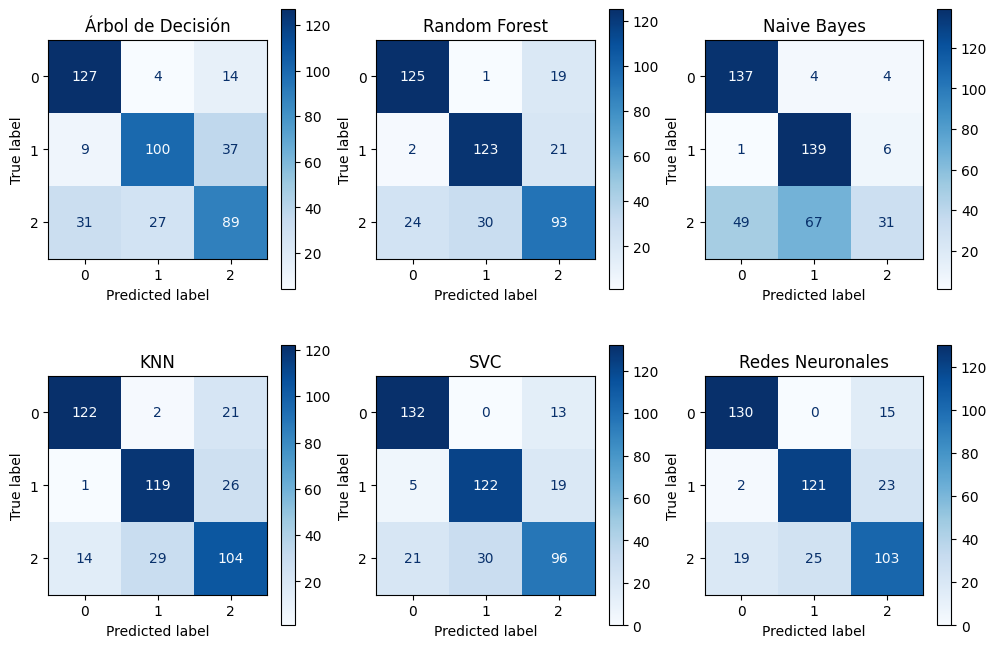

In [73]:
modelos = ["Árbol de Decisión", "Random Forest", "Naive Bayes", "KNN", "SVC", "Redes Neuronales"]
# Graficar matriz de confusión para cada modelo
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for ax, y_pred, title in zip(axes.flatten(), [y_predDT, y_predRF, y_predNB, y_predKNN, y_predSVM, y_predRNA], 
                             modelos):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=ax, cmap="Blues")
    ax.set_title(title)

plt.show()

Accuracy Árbol de Decisión: 0.7214611872146118
Accuracy Random Forest: 0.7785388127853882
Accuracy Naive Bayes: 0.7009132420091324
Accuracy KNN: 0.7876712328767124
Accuracy SVC: 0.7990867579908676
Accuracy Redes Neuronales: 0.8082191780821918


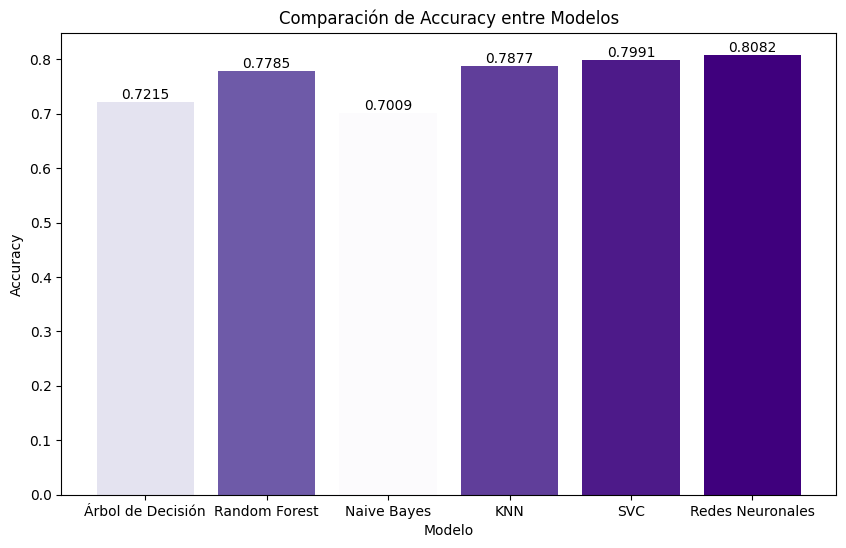

In [77]:
print("Accuracy Árbol de Decisión:", accuracy_score(y_test, y_predDT))
print("Accuracy Random Forest:", accuracy_score(y_test, y_predRF))
print("Accuracy Naive Bayes:", accuracy_score(y_test, y_predNB))
print("Accuracy KNN:", accuracy_score(y_test, y_predKNN))
print("Accuracy SVC:", accuracy_score(y_test, y_predSVM))
print("Accuracy Redes Neuronales:", accuracy_score(y_test, y_predRNA))

accuracy_values = [
    accuracy_score(y_test, y_predDT),
    accuracy_score(y_test, y_predRF),
    accuracy_score(y_test, y_predNB),
    accuracy_score(y_test, y_predKNN),
    accuracy_score(y_test, y_predSVM),
    accuracy_score(y_test, y_predRNA),
]

# Normalizar los valores de R²
norm = Normalize(vmin=min(accuracy_values), vmax=max(accuracy_values))

cmap = colormaps['Purples']

# Asignar colores a las barras
colors = [cmap(norm(value)) for value in accuracy_values]

plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, accuracy_values, color=colors)
plt.title('Comparación de Accuracy entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('Accuracy')

# Agregar etiquetas a las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')
    
plt.show()

Tiempo de entrenamiento (Árbol de Decisión): 0.02866077423095703
Tiempo de entrenamiento (Random Forest): 2.1788225173950195
Tiempo de entrenamiento (Naive Bayes): 0.018021583557128906
Tiempo de entrenamiento (KNN): 0.015994787216186523
Tiempo de entrenamiento (SVC): 0.04463052749633789
Tiempo de entrenamiento (Redes Neuronales): 0.5077061653137207


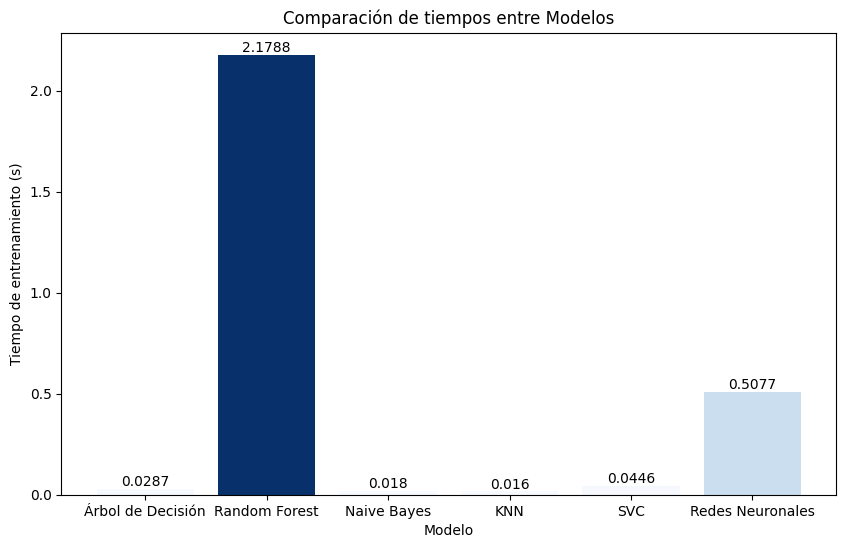

In [75]:
# Comparar tiempos de ejecución
time_values = [
    tiempo_entrenamiento_dt,
    tiempo_entrenamiento_rf,
    tiempo_entrenamiento_nb,
    tiempo_entrenamiento_knn,
    tiempo_entrenamiento_svm,
    tiempo_entrenamiento_rna
]

print("Tiempo de entrenamiento (Árbol de Decisión):", tiempo_entrenamiento_dt)
print("Tiempo de entrenamiento (Random Forest):", tiempo_entrenamiento_rf)
print("Tiempo de entrenamiento (Naive Bayes):", tiempo_entrenamiento_nb)
print("Tiempo de entrenamiento (KNN):", tiempo_entrenamiento_knn)
print("Tiempo de entrenamiento (SVC):", tiempo_entrenamiento_svm)
print("Tiempo de entrenamiento (Redes Neuronales):", tiempo_entrenamiento_rna)

# Normalizar los valores
norm = Normalize(vmin=min(time_values), vmax=max(time_values))

cmap = colormaps['Blues']

# Asignar colores a las barras
colors = [cmap(norm(value)) for value in time_values]

plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, time_values, color=colors)
plt.title('Comparación de tiempos entre Modelos')
plt.xlabel('Modelo')
plt.ylabel('Tiempo de entrenamiento (s)')

# Agregar etiquetas a las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

plt.show()

In [76]:
print("Reporte de clasificación para Árbol de Decisión:\n", classification_report(y_test, y_predDT))
print("Reporte de clasificación para Random Forest:\n", classification_report(y_test, y_predRF))
print("Reporte de clasificación para Naive Bayes:\n", classification_report(y_test, y_predNB))
print("Reporte de clasificación para KNN:\n", classification_report(y_test, y_predKNN))
print("Reporte de clasificación para SVC:\n", classification_report(y_test, y_predSVM))
print("Reporte de clasificación para RNA:\n", classification_report(y_test, y_predRNA))

Reporte de clasificación para Árbol de Decisión:


               precision    recall  f1-score   support

        Cara       0.76      0.88      0.81       145
   Económica       0.76      0.68      0.72       146
  Intermedia       0.64      0.61      0.62       147

    accuracy                           0.72       438
   macro avg       0.72      0.72      0.72       438
weighted avg       0.72      0.72      0.72       438

Reporte de clasificación para Random Forest:
               precision    recall  f1-score   support

        Cara       0.83      0.86      0.84       145
   Económica       0.80      0.84      0.82       146
  Intermedia       0.70      0.63      0.66       147

    accuracy                           0.78       438
   macro avg       0.78      0.78      0.78       438
weighted avg       0.77      0.78      0.78       438

Reporte de clasificación para Naive Bayes:
               precision    recall  f1-score   support

        Cara       0.73      0.94      0.83       145
   Económica       0.66      0.95     

## Conclusión

- Mejor modelo general: Las Redes Neuronales obtuvieron la mayor precisión (80.82%), con un tiempo de entrenamiento moderado (0.51 segundos). Este modelo ofrece el mejor equilibrio entre precisión y complejidad computacional.
- Mejor modelo para implementación rápida: SVC logró un accuracy muy cercano al mejor (79.91%) con solo 0.045 segundos de entrenamiento, lo que representa una excelente relación rendimiento/tiempo.
- Compromiso eficiencia-precisión: KNN ofrece un buen balance con 78.77% de precisión y el menor tiempo de entrenamiento (0.016 segundos).
- No recomendados: Aunque Random Forest tiene una precisión aceptable, su tiempo de entrenamiento es significativamente mayor. Naive Bayes y Árbol de Decisión obtuvieron las precisiones más bajas.
- Observación sobre las matrices: La mayoría de los modelos parecen tener dificultades similares con ciertas clases, lo que sugiere que algunas características del conjunto de datos pueden ser inherentemente difíciles de clasificar.

En resumen, recomendaría utilizar las Redes Neuronales para implementaciones donde la precisión sea crítica, o SVC para situaciones donde se necesite un buen balance entre velocidad y precisión. Para aplicaciones en tiempo real con recursos limitados, KNN podría ser la mejor opción.